In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list="0"
set_session(tf.Session(config=config))

'Import keras'
from keras.models import Model, Sequential
from keras.layers import *
from keras import regularizers
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
from tqdm import tqdm
import pandas as pd

'import spectral Python'
import spectral.io.envi as envi

from ganTraining.GANModel_1d import GANModel_1d

%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)
Using TensorFlow backend.


In [2]:
'Define the GAN Model used in the experiments'
obj = GANModel_1d(img_rows=240, dropout=0.0, genFilters=250, disFilters=20, filterSize=11)
gen1 = obj.genModel_CV_L6s2()
gen1.load_weights('/Volume2/arunFiles/pythonCodeFiles/CRISM_repLearning/modelsOnYukiModel_cR_wGAN/Models/Model-4_small/generator/gen_cR_75.h5')
gen1.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3750)              191250    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3750)              15000     
_________________________________________________________________
reshape_1 (Reshape)          (None, 15, 250)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 250)           0         
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 30, 250)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 125)           343875    
___________________________________________________________

In [3]:
'Define the GAN Model used in the experiments'
dis1 = obj.disModel_CV_L6s2()
dis1.load_weights('/Volume2/arunFiles/pythonCodeFiles/CRISM_repLearning/modelsOnYukiModel_cR_wGAN/Models/Model-4_small/discriminator/dis_cR_75.h5')
dis1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 120, 20)           240       
_________________________________________________________________
dropout_6 (Dropout)          (None, 120, 20)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 60, 40)            8840      
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 40)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 30, 80)            35280     
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 80)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 15, 160)           140960    
__________

In [4]:
model_l2 = Sequential()
'Layer-1'
'In: 240 X 1, depth =1'
'Out:120 X 1, depth =25'
model_l2.add(Conv1D(filters=20, kernel_size=11, strides=2, input_shape=(240,1),
                   weights=dis1.layers[0].get_weights(), padding='same', activation='relu'))
#model_l2.add(Dropout(0.5))
'Layer-2'
'In: 120 X 1, depth =25'
'Out: 60 X 1, depth =50'
model_l2.add(Conv1D(filters=40, kernel_size=11, strides=2, 
                   weights=dis1.layers[2].get_weights(), padding='same', activation='relu'))

'Layer-3'
'In: 60 X 1, depth =50'
'Out: 30 X 1, depth =100'
model_l2.add(Conv1D(filters=80, kernel_size=11, strides=2, 
                   weights=dis1.layers[4].get_weights(), padding='same', activation='relu'))

'Layer-4'
'In: 30 X 1, depth =100'
'Out: 15 X 1, depth =200'
model_l2.add(Conv1D(filters=160, kernel_size=11, strides=2, 
                   weights=dis1.layers[6].get_weights(), padding='same', activation='relu'))
model_l2.add(Flatten())
model_l2.compile(loss='binary_crossentropy', optimizer=Adam())

In [5]:
'Generate spectra from the generator'
try_input = np.random.rand(500000, 50)
genSpectra = np.squeeze(gen1.predict(try_input))
print genSpectra.shape

(500000, 240)


In [6]:
'Get the Discriminator features for the generated spectra'
genSpectra = genSpectra.reshape(genSpectra.shape[0], genSpectra.shape[1],1)

'Predict activations on validation set'
genSpectra_Preds = model_l2.predict(genSpectra)

In [7]:
'Extracting CR MICA Spectrum'
crsliName = '/Volume1/data/CRISM/AMS/sabcondv3_old//mica5EM_CR.sli'
crsliHdrName = '/Volume1/data/CRISM/AMS/sabcondv3_old//mica5EM_CR.sli.hdr'

'Read in the spectra'
crmicaSLI = envi.open(crsliHdrName, crsliName)
crmica_data = crmicaSLI.spectra
crmica_data = crmica_data[:,4:244]
header = envi.read_envi_header(crsliHdrName)
'Extract the wavelength'
wvl= header['wavelength']
wvl=np.asarray(wvl, dtype='f4')
wvl = wvl[4:244]


'Reshape to pass on to discriminator'
crmica_data = crmica_data.reshape(crmica_data.shape[0], crmica_data.shape[1],1)
'Get the predictions at output layer'
mica_dataPreds_l2 = model_l2.predict(crmica_data)
print mica_dataPreds_l2.shape

(5, 2400)


In [31]:
from  sklearn.metrics.pairwise import cosine_similarity as cdist
emNum = 0
dist = np.squeeze(cdist(mica_dataPreds_l2[emNum,:], genSpectra_Preds))
idxSorted = np.argsort(-dist)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


0.84623516


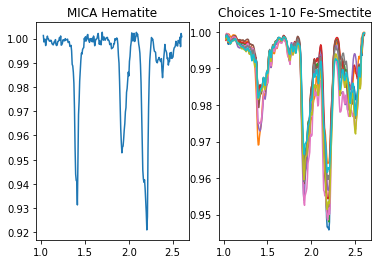

In [30]:
sNo=1
fig1=plt.figure()
ax = plt.subplot(1,2,1)
plt.plot(wvl, np.squeeze(crmica_data[emNum,:,:]))
plt.title('MICA Hematite')

temp = np.squeeze(genSpectra[idxSorted[sNo:(sNo+10)],:,:])
ax = plt.subplot(1,2,2)
plt.plot(wvl, temp.T)
plt.title('Choices 1-10 Fe-Smectite')

print dist[idxSorted[sNo+10]]